# APS 1 - Visão de Máquina
### Lucca Lozano Nasser

In [12]:
import sys
import cv2

print("Python executable:", sys.executable)
print("OpenCV version:", cv2.__version__)


Python executable: c:\Users\lucca\anaconda3\python.exe
OpenCV version: 4.11.0


In [13]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Ex. 1

In [14]:
img_1a = cv2.imread('Figuras_APS1/Fig_APS1_1a.bmp', cv2.IMREAD_COLOR)
img_1b = cv2.imread('Figuras_APS1/Fig_APS1_1b.bmp', cv2.IMREAD_COLOR)

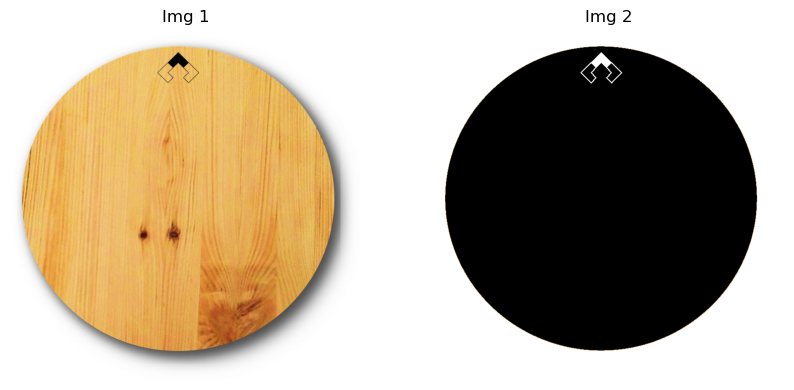

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(cv2.cvtColor(img_1a, cv2.COLOR_BGR2RGB))
ax[0].set_title('Img 1')
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(img_1b, cv2.COLOR_BGR2RGB))
ax[1].set_title('Img 2')
ax[1].axis('off')
plt.show()

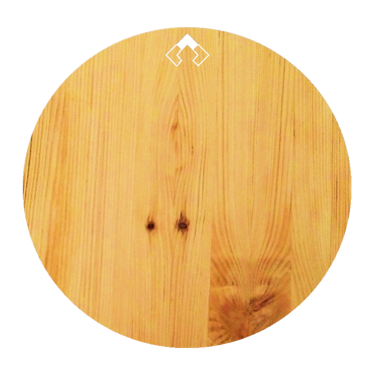

In [16]:
# subtract images
img1_diff = cv2.subtract(img_1a, img_1b)
plt.imshow(img1_diff, cmap='gray')
plt.axis('off')

img1_add = cv2.add(img1_diff, img_1b)
img1_add = cv2.cvtColor(img1_add, cv2.COLOR_BGR2RGB)
plt.imshow(img1_add)
plt.axis('off')
plt.show()

Height:  751
Width =  755


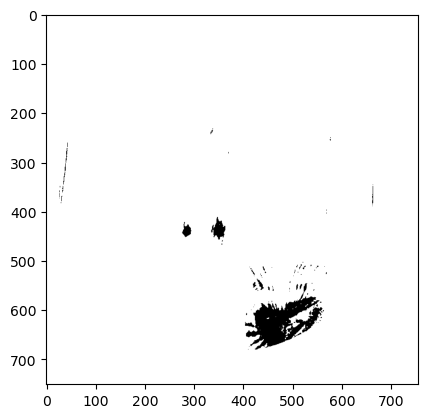

In [17]:
img1_gray = cv2.cvtColor(img1_add, cv2.COLOR_BGR2GRAY)

(h, w) = img1_gray.shape

print('Height: ', h)
print('Width = ', w)

img1_bnw = np.zeros((h,w), dtype = "uint8")

threshold = 100

for i in range(h):
    for j in range(w):

        if img1_gray[i,j] >= threshold:
            img1_bnw[i,j] = 255

plt.figure("Fig Bin")
plt.imshow(img1_bnw, cmap='gray')
plt.show()

In [18]:
black = 0
total = h * w
for i in range(h):
    for j in range(w):

        if img1_bnw[i,j] == 0:
            black += 1
        

percent = (black / total) * 100

print('Pixels pretos:', black)
print('Total de pixels:', total)
print(f'% de nós/falhas = {percent:.2f}%')

Pixels pretos: 9935
Total de pixels: 567005
% de nós/falhas = 1.75%


## Ex. 2

In [19]:
img2_a = cv2.imread('Figuras_APS1/Fig_APS1_2a.bmp', cv2.IMREAD_COLOR)
img2_b = cv2.imread('Figuras_APS1/Fig_APS1_2b.bmp', cv2.IMREAD_GRAYSCALE)

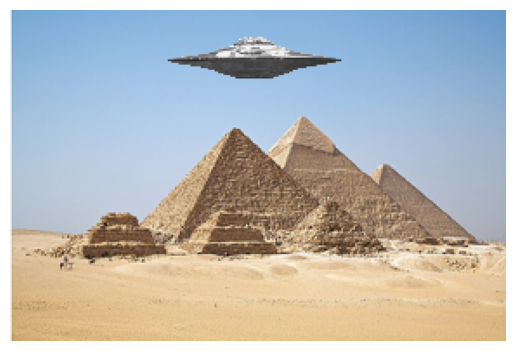

In [20]:
img2_a = cv2.imread('Figuras_APS1/Fig_APS1_2a.bmp', cv2.IMREAD_COLOR)
img2_b = cv2.imread('Figuras_APS1/Fig_APS1_2b.bmp', cv2.IMREAD_GRAYSCALE)

_, mask = cv2.threshold(img2_b, 250, 255, cv2.THRESH_BINARY_INV)

img2_a_rbg = cv2.cvtColor(img2_a, cv2.COLOR_BGR2RGB)
img2_b_rbg = cv2.cvtColor(img2_b, cv2.COLOR_BGR2RGB)

ovni_resize = cv2.resize(img2_b, (img2_a.shape[1], img2_a.shape[0]))
mask = cv2.resize(mask, (img2_a.shape[1], img2_a.shape[0]))

mask_inv = cv2.bitwise_not(mask)

egito_bg = cv2.bitwise_and(img2_a_rbg, img2_a_rbg, mask=mask_inv)
egito_fg = cv2.bitwise_and(img2_b_rbg, img2_b_rbg, mask=mask)

img_final = cv2.add(egito_bg, egito_fg)

plt.imshow(img_final)
plt.axis('off')
plt.show()

## Ex. 3

In [21]:
cap = cv2.VideoCapture('Figuras_APS1/Video_APS1_3.avi')
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f'Número de frames: {num_frames}')

Número de frames: 309


In [22]:
if not cap.isOpened():
    print("Erro ao abrir o vídeo.")
    exit()

# 2. Criação do subtrator de fundo
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Encerra quando não há mais frames

    # 3. Aplicação do subtrator de fundo para obter a máscara do primeiro plano
    fg_mask = bg_subtractor.apply(frame)
    
    # 4. Operações morfológicas para reduzir o ruído
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)
    
    # 5. Binarização do FG mask (garante somente valores 0 ou 255)
    ret2, binary_fg = cv2.threshold(fg_mask, 128, 255, cv2.THRESH_BINARY)
    
    # 6. Detecção de contornos com base no FG mask binarizado
    contours, _ = cv2.findContours(binary_fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 7. Criação da imagem de saída (preta)
    output = np.zeros_like(frame)
    
    # 8. Processa cada contorno de área significativa
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 500:  # Filtra ruídos menores
            x, y, w, h = cv2.boundingRect(cnt)
            
            # Extrai o ROI do FG mask binarizado correspondente ao retângulo
            roi_binary = binary_fg[y:y+h, x:x+w]
            
            # Cria uma máscara booleana para os pixels do carro
            mask_roi = (roi_binary == 255)
            
            # Pinta de vermelho na imagem de saída onde o ROI indicar objeto
            output_roi = output[y:y+h, x:x+w]
            output_roi[mask_roi] = [0, 0, 255]
            output[y:y+h, x:x+w] = output_roi

    # Redimensiona as imagens para exibição com um fator menor (30% do tamanho original)
    scale = 0.3  # ajuste conforme necessário para a visualização desejada
    frame_resized = cv2.resize(frame, (0, 0), fx=scale, fy=scale)
    output_resized = cv2.resize(output, (0, 0), fx=scale, fy=scale)
    
    # Exibe as janelas com os frames redimensionados
    cv2.imshow("Frame Original", frame_resized)
    cv2.imshow("Carros Refinados (Vermelho)", output_resized)
    
    # Posiciona as janelas lado a lado
    cv2.moveWindow("Frame Original", 100, 100)
    cv2.moveWindow("Carros Refinados (Vermelho)", 100 + frame_resized.shape[1] + 10, 100)
    
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


## Ex. 4

In [ ]:
img4_a = cv2.imread('Figuras_APS1/Fig_APS1_4a.bmp', cv2.IMREAD_GRAYSCALE)
img4_b = cv2.imread('Figuras_APS1/Fig_APS1_4b.bmp', cv2.IMREAD_GRAYSCALE)

In [ ]:
# Carrega a imagem original (imagem médica) e o padrão de iluminação em escala de cinza
img_original = cv2.imread('Fig_APS1_4a.png', cv2.IMREAD_GRAYSCALE)
img_iluminacao = cv2.imread('Fig_APS1_4b.png', cv2.IMREAD_GRAYSCALE)

# Converte as imagens para float para evitar problemas na divisão/multiplicação
O = img_original.astype(np.float32)
I = img_iluminacao.astype(np.float32)

# Calcula a média de intensidade do padrão de iluminação
media_I = np.mean(I)

# Cria a matriz de correção K (evita divisão por zero adicionando um epsilon)
epsilon = 1e-6
K = media_I / (I + epsilon)

# Aplica a correção à imagem original (multiplicação pixel a pixel)
C = O * K

# Garante que os valores fiquem no intervalo [0, 255] e converte para uint8
C = np.clip(C, 0, 255).astype(np.uint8)

# Exibe as imagens: Original, Padrão de Iluminação e Corrigida
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(O, cmap='gray')
plt.title('Imagem Original (O)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(I, cmap='gray')
plt.title('Padrão de Iluminação (I)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(C, cmap='gray')
plt.title('Imagem Corrigida (C)')
plt.axis('off')

plt.show()


AttributeError: 'NoneType' object has no attribute 'astype'

In [ ]:
n = img4_b.shape[0] * img4_b.shape[1]

sum_i = np.sum(img4_b.astype(np.float64))

k = (sum_i / n) / img4_b
img4_b.astype('int32')

array([[231, 101,  96, ..., 107, 117, 242],
       [231, 101,  96, ..., 107, 117, 242],
       [231, 101,  96, ..., 107, 117, 242],
       ...,
       [231, 104,  99, ...,  98, 109, 241],
       [231, 100,  95, ...,  94, 105, 240],
       [245, 189, 187, ..., 187, 191, 249]])

(-0.5, 267.5, 265.5, -0.5)

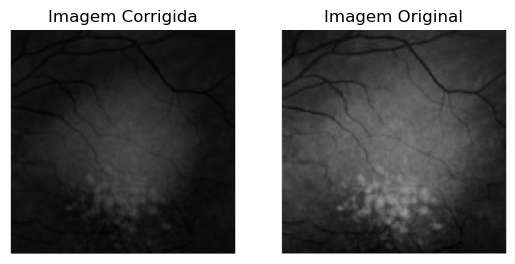

In [ ]:
matrix_c = np.where(k == 1, img4_a, np.where(k > 1, img4_a * k, img4_a / k))
matrix_c_clip = np.clip(matrix_c, 0, 255).astype('uint8')

plt.subplot(1, 2, 1)
plt.imshow(matrix_c, cmap='gray')
plt.title('Imagem Corrigida')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img4_a, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')